In [6]:
# import packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# import custom functions
os.chdir('..')
from scripts.utils import img_viewer # this function is custom function I have written myself that gives me
                                     # a lot of freedom in visualizing various images in various combinations
                                     # of subplots

In [20]:
# definitions

# data path lists (i/o)
data_dir = '/Users/simpleai/Downloads/RFMiD_All_Classes_Dataset' # the path I have downloaded data into
root_dir = '/Users/simpleai/Desktop/az_task/results/task1' # the output path of this notebook
os.makedirs(root_dir, exist_ok=True) # making the output directory

# the downloaded dataset has already divided the train, val and test datasets
data_type = ['Train', 'Val', 'Test']

# defining some empty dictionaries and dataframes for saving the information in them
image_path_dir_dict = {}
label_path_df = {}
global_df = pd.DataFrame() # this dataframe will comtain all the train/val/test labels

# Visualizing 50 images in a view-friendly way

* for the sake of easy visualization. 2 subplots each containing 25 images (5 by 5) will be made
* the images will be selected randomly for this visualization


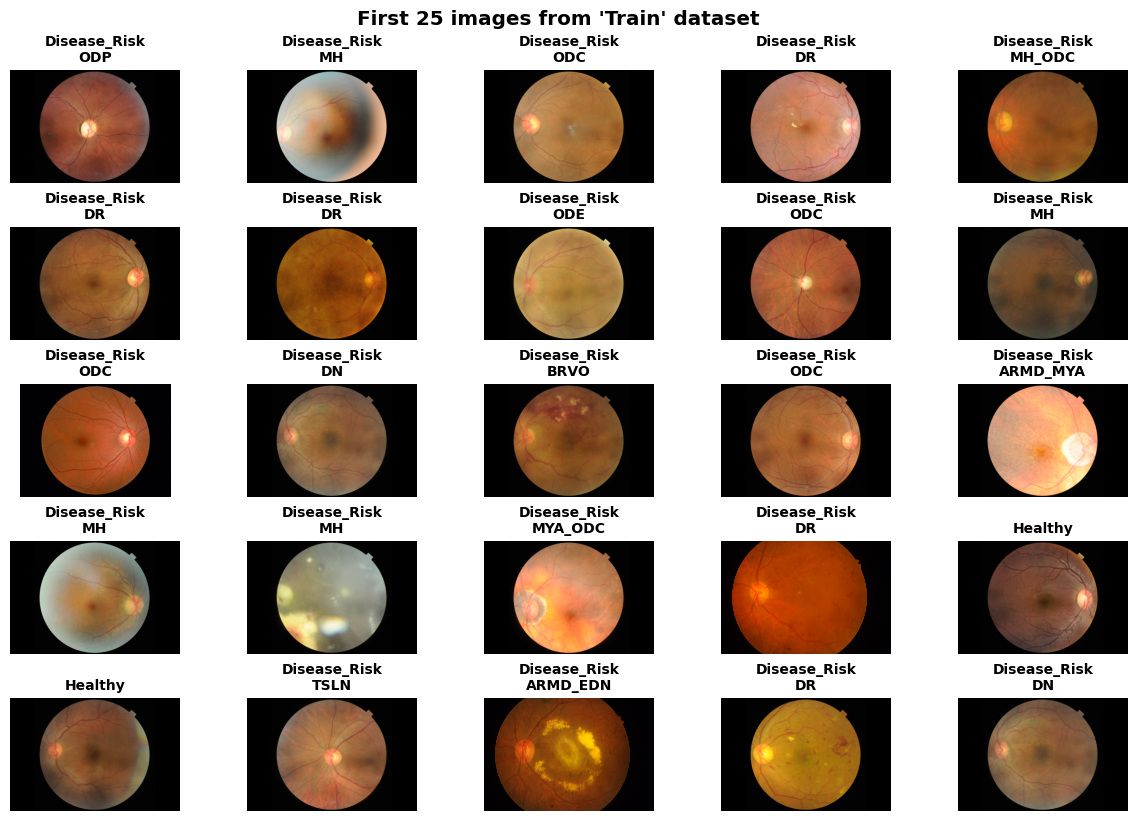

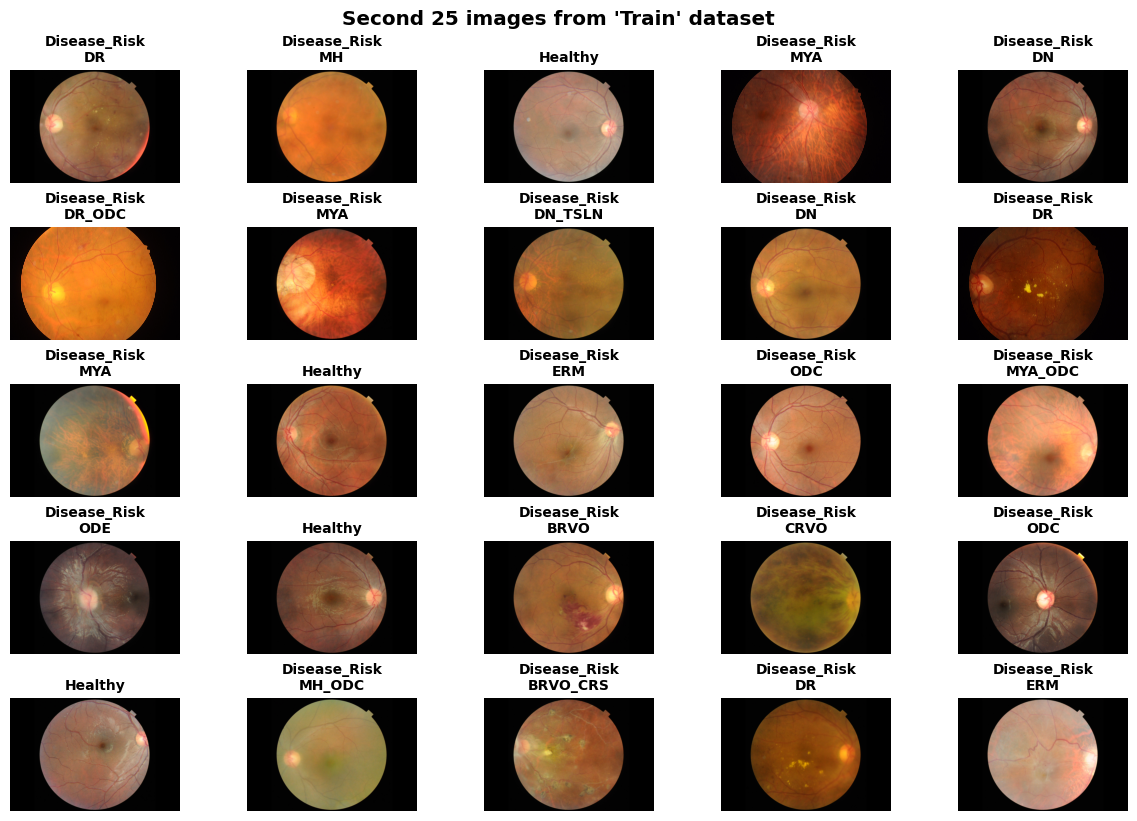

In [21]:
for data in data_type:
    image_path_dir_dict[data] = os.path.split(glob.glob(os.path.join(data_dir, f"*/*{data}*/*.png"))[0])[0]
    label_path_df[data] = pd.read_csv([i for i in glob.glob(os.path.join(data_dir, f"*/*{data}*.csv"))][0])
    
    # adding path to data to the csv file
    label_path_df[data]['image_path'] = [os.path.join(image_path_dir_dict[data],f"{i+1}.png") for i in label_path_df[data].index]
    
    # adding the data_type (train/val/test) to the label data
    label_path_df[data]['type'] = [data for i in label_path_df[data].index]
    global_df = pd.concat([global_df, label_path_df[data]], axis=0)
    global_df = global_df.reset_index(drop=True)

    # plotting 2 images each having a 5 by 5 (25) images
    if data=='Train':
        # random visualization of 50 images from the train set
        img_list = list(np.random.randint(0,label_path_df[data].shape[0],50))
    
        mia_dict = ['First', 'Second']
        for mia in range(2):
            img_arr_list = []
            img_title_list = []
            for i in range(5):
                img_row_list = []
                img_row_title_list = []
                for j in range(5):
                    # number of the image
                    ij = mia*25 + i*5 + j
                    # loading the image
                    img_row_list.append(np.asarray(Image.open(label_path_df[data].loc[img_list[ij],'image_path'])))
                    # making the label
                    img_title = ''
                    for col in [i for i in label_path_df[data].columns][1:-2]:
                        if label_path_df[data].loc[img_list[ij],col]==1 and col=='Disease_Risk':
                            img_title = f"{img_title}{col}\n"
                        elif label_path_df[data].loc[img_list[ij],col]==1:
                            img_title = f"{img_title}{col}_"
                    # labeling the images with no available label, based on the paper they are "healthy"
                    if img_title == '':
                        img_title = 'Healthy '
                    img_row_title_list.append(img_title[:-1])
                img_arr_list.append(img_row_list)
                img_title_list.append(img_row_title_list)
            
            img_viewer(img_arr_list, img_title_list, f"{mia_dict[mia]} 25 images from '{data}' dataset",
                       image_title_pos_y=1.05,
                       i=5, j=5, figsize=(12,8), panel_title_fontsize='medium',
                       title_font_size='x-large', save=True, 
                       save_path=f"{root_dir}/mia_25_{mia}")

# center-cropping images

* looking at above images, one quickly notices that images have quite a lot of black background which can be removed from the width of the image.
* while I can think of several different ways to isolate the Fundus image (circular shape) by some thresholding technique or some FFT filtering, The simplest method to try here is to center crop the images.
* the main centercropping function is applied in the Dataset class in an on-the-fly way simultaneous to loading the images, however for the sake of visualizations, I plotting the same above images centercropped down below "only on the second 25 images"
* as reflected below, the center-cropping seem to have been efficiently able to get rid of most of the extra black background

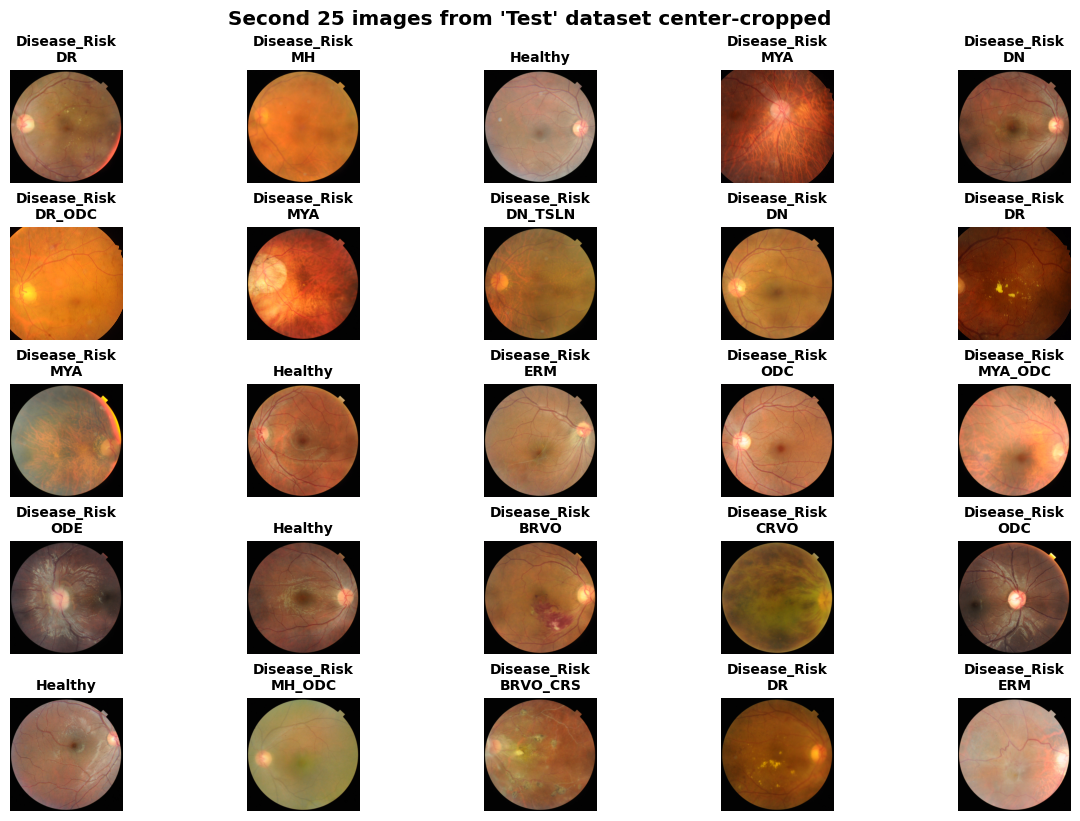

In [22]:
for row,img_row in enumerate(img_arr_list):
    for col,img in enumerate(img_row):
        j_radius = int(img.shape[1]/2)
        i_radius = int(img.shape[0]/2)
        if j_radius > i_radius:
            img = img[:,(j_radius-i_radius):(j_radius+i_radius),:]
        elif j_radius < i_radius:
            img = img[(i_radius-j_radius):(i_radius+j_radius),:,:]
            
        img_arr_list[row][col] = img
        
mia_dict = ['First', 'Second']
mia = 1
img_viewer(img_arr_list, img_title_list, f"{mia_dict[mia]} 25 images from '{data}' dataset center-cropped",
       image_title_pos_y=1.05,
       i=5, j=5, figsize=(12,8), panel_title_fontsize='medium',
       title_font_size='x-large', save=True, 
       save_path=f"{root_dir}/centercropped_mia_25_{mia}")

# summerizing the data class distribution
1. all the data
* results reflected below show that all th train/val/test datasets have the same distribution of classes and therefore suffering from the same level of class imbalance
* Here we should note that those according to the reference of the dataset, images not labeled are helathy and normal images.
* we should also notice that the labelings in this dataset are not mutually exclusive. Meaning that some images are rated positive for more than one of the diseases
* a through description of the labels can be found here: https://www.mdpi.com/2306-5729/8/2/29

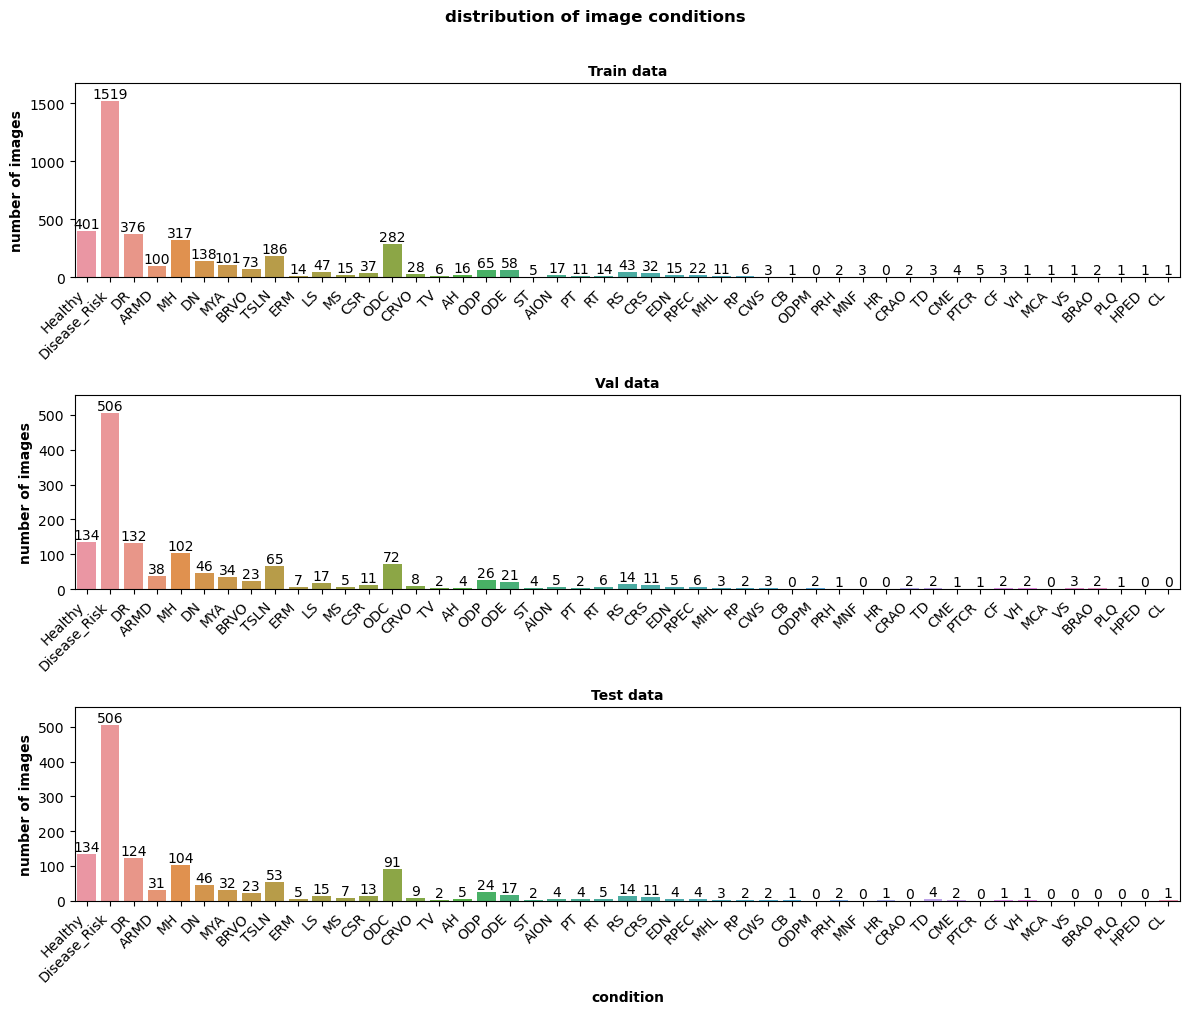

In [23]:
# 1. barplots of number of images per category
fig, ax = plt.subplots(3,1,figsize=(12,10))
for d,data in enumerate(data_type):
    # curating data for barplot visualization
    metadata_df = label_path_df[data].iloc[:,1:-2]
    healthy_df = pd.DataFrame({'Healthy':[0 if metadata_df.loc[i,'Disease_Risk']==1 else 1 for i in metadata_df.index]})
    metadata_df = pd.concat([healthy_df, metadata_df], axis=1)
    sum_metadata_df = pd.DataFrame(metadata_df.sum(), columns=['num_cases'])
    sum_metadata_df['condition'] = [i for i in sum_metadata_df.index]
    
    # plotting the data
    sns.barplot(sum_metadata_df, x='condition', y='num_cases', ax=ax[d])
    
    # adjusting the plot for better visualization
    ax[d].set_ylim([0,sum_metadata_df['num_cases'].max()*1.1])
    xlabel = '' if not d==2 else 'condition'
    ax[d].set_xlabel(xlabel, fontsize='medium', fontweight='bold')
    ax[d].set_ylabel('number of images', fontsize='medium', fontweight='bold')
    ax[d].set_xticklabels(ax[d].get_xticklabels(), rotation=45, ha='right')
    ax[d].set_title(f"{data} data", fontsize='medium', fontweight='bold')
    for i in ax[d].containers:
        ax[d].bar_label(i,)
        
    plt.suptitle('distribution of image conditions', y=1.01, fontsize='large',
                 fontweight='bold')
    plt.tight_layout()
    
plt.savefig(f"{root_dir}/data_distribution.png", dpi=600, bbox_inches='tight')
plt.show()

# data selection for classification
* two main ways of classification seems to be interesting here:
1. binary classification of disease versus healthy
2. multiclass classification of the images. For this task the following consitions were selected based on the number of images present in the dataset from every class:
* **'Healthy':** not labeled
* **'DR':** Diabetic Retinopathy
* **'ARMD':** Age-Related Macular Degeneration
* **'MH':** Media Haze, 
* **'DN':** Drusens, 
* **'TSLN':** Tessellation, 
* **'ODC':** Optic Disc Cupping

### preparing data csv files containing labels and path to images for both classification approaches

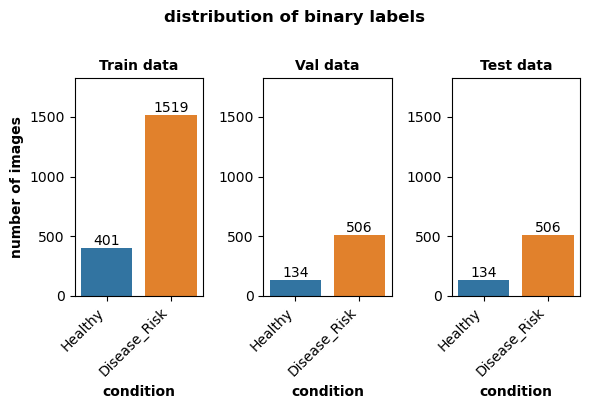

In [24]:
binary_label_dict = {}
binary_label_dict['ID'] = [i for i in global_df['ID']]
binary_label_dict['Healthy'] = [1 if i==0 else 0 for i in global_df['Disease_Risk']]
binary_label_dict['Disease_Risk'] = [1 if i==1 else 0 for i in global_df['Disease_Risk']]
binary_label_dict['label'] = [i for i in global_df['Disease_Risk']]
binary_label_dict['image_path'] = [i for i in global_df['image_path']]
binary_label_dict['type'] = [i for i in global_df['type']]
binary_label_df = pd.DataFrame(binary_label_dict)
binary_label_df.to_csv(f"{root_dir}/binary_classification_metadata.csv")
# vizualizing number of selected data for binary classification
fig, ax = plt.subplots(1,3,figsize=(6,4))
ylim_max = 0
for d,data in enumerate(data_type):
    binary_label_df_type = binary_label_df.loc[binary_label_df['type']==data, ['Healthy', 'Disease_Risk']]
    sum_binary_label_df_type = pd.DataFrame(binary_label_df_type.sum(), columns=['num_classes'])
    sum_binary_label_df_type['condition'] = [i for i in sum_binary_label_df_type.index]
    # plotting the data
    sns.barplot(sum_binary_label_df_type, x='condition', y='num_classes', ax=ax[d])
    
    # adjusting the plot for better visualization
    ylim_max = max(sum_binary_label_df_type['num_classes'].max()*1.2, ylim_max)
    ax[d].set_ylim([0,ylim_max])
    ylabel = '' if not d==0 else 'number of images'
    ax[d].set_xlabel('condition', fontsize='medium', fontweight='bold')
    ax[d].set_ylabel(ylabel, fontsize='medium', fontweight='bold')
    ax[d].set_xticklabels(ax[d].get_xticklabels(), rotation=45, ha='right')
    ax[d].set_title(f"{data} data", fontsize='medium', fontweight='bold')
    for i in ax[d].containers:
        ax[d].bar_label(i,)
    plt.suptitle('distribution of binary labels', y=1.01, fontsize='large',
                 fontweight='bold')
    plt.tight_layout()
plt.savefig(f"{root_dir}/binary_data_distribution.png", dpi=600, bbox_inches='tight')
plt.show()

In [25]:
# Label dataframe containing labels and path to every image
binary_label_df

,ID,Healthy,Disease_Risk,label,image_path,type
0,1,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train
1,2,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train
2,3,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train
3,4,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train
4,5,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train
...,...,...,...,...,...,...
3195,636,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test
3196,637,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test
3197,638,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test
3198,639,0,1,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test


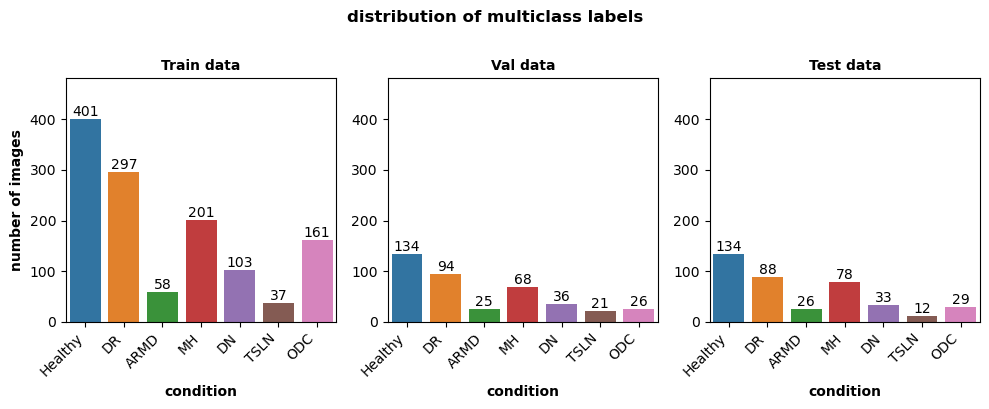

In [26]:
multiclass_label_dict = {}
multiclass_label_dict['ID'] = [i for i in global_df['ID']]
multiclass_label_dict['image_path'] = [i for i in global_df['image_path']]
multiclass_label_dict['type'] = [i for i in global_df['type']]
multiclass_label_dict['Healthy'] = [1 if i==0 else 0 for i in global_df['Disease_Risk']]
#multiclass_label_dict['label'] = [0 for i in global_df['image_path']]
for c,col in enumerate(['DR', 'ARMD', 'MH', 'DN', 'TSLN', 'ODC']):
    multiclass_label_dict[col] = [1 if i==1 else 0 for i in global_df[col]]
    
multiclass_label_df = pd.DataFrame(multiclass_label_dict)
# removing rows that belong to no class or more than 1 class
multiclass_label_df['sum']=[i for i in multiclass_label_df.drop(['image_path', 'ID', 'type'], axis=1).sum(axis=1)]
multiclass_label_df = multiclass_label_df.loc[multiclass_label_df['sum']==1, multiclass_label_df.columns!='sum']
multiclass_label_df = multiclass_label_df.reset_index(drop=True)
multiclass_label_df.to_csv(f"{root_dir}/multiclass_classification_metadata.csv")
# vizualizing number of selected data for binary classification
fig, ax = plt.subplots(1,3,figsize=(10,4))
ylim_max = 0
for d,data in enumerate(data_type):
    multiclass_label_df_type = multiclass_label_df.loc[multiclass_label_df['type']==data, ~multiclass_label_df.columns.isin(['ID', 'image_path', 'type'])]
    sum_multiclass_label_df_type = pd.DataFrame(multiclass_label_df_type.sum(), columns=['num_classes'])
    sum_multiclass_label_df_type['condition'] = [i for i in sum_multiclass_label_df_type.index]
    # plotting the data
    sns.barplot(sum_multiclass_label_df_type, x='condition', y='num_classes', ax=ax[d])
    
    # adjusting the plot for better visualization
    ylim_max = max(sum_multiclass_label_df_type['num_classes'].max()*1.2, ylim_max)
    ax[d].set_ylim([0,ylim_max])
    ylabel = '' if not d==0 else 'number of images'
    ax[d].set_xlabel('condition', fontsize='medium', fontweight='bold')
    ax[d].set_ylabel(ylabel, fontsize='medium', fontweight='bold')
    ax[d].set_xticklabels(ax[d].get_xticklabels(), rotation=45, ha='right')
    ax[d].set_title(f"{data} data", fontsize='medium', fontweight='bold')
    for i in ax[d].containers:
        ax[d].bar_label(i,)
    plt.suptitle('distribution of multiclass labels', y=1.01, fontsize='large',
                 fontweight='bold')
    plt.tight_layout()

plt.savefig(f"{root_dir}/multiclass_data_distribution.png", dpi=600, bbox_inches='tight')
plt.show()

In [27]:
multiclass_label_df

,ID,image_path,type,Healthy,DR,ARMD,MH,DN,TSLN,ODC
0,1,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train,0,1,0,0,0,0,0
1,2,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train,0,1,0,0,0,0,0
2,3,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train,0,1,0,0,0,0,0
3,5,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train,0,1,0,0,0,0,0
4,6,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Train,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2057,628,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test,1,0,0,0,0,0,0
2058,629,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test,1,0,0,0,0,0,0
2059,630,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test,0,0,0,0,0,0,1
2060,631,/Users/simpleai/Downloads/RFMiD_All_Classes_Da...,Test,0,0,0,0,0,0,1
